# Do Not Delete!

In [ ]:
# DO NOT REMOVE THESE
%load_ext autoreload
%autoreload 2

In [ ]:
# DO NOT REMOVE This
%reload_ext autoreload

In [ ]:
## DO NOT REMOVE
## import local src module -
## src in this project will contain all your local code
## clean_data.py, model.py, visualize.py, custom.py

#import src.base with alias to avoid namespace clashes

from src import base as fis

In [ ]:
fis.test_base()

# Import Libraries

In [3]:
# !pip install imblearn

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Resampling Methods
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression

# Model Tuning and Cross Validation
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

# Model metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve



# Data Importing

Twenty-eight of the thirty feature columns are masked. Also, according to the data source, those twenty-eight columns have been transformed using Principle Component Analysis, so we cannot easily speculate about what any particular column may represent. We know only the amount of each purchase and time it was made (measured in seconds from the first to the last transaction represented).  

We used the pandas_profiling function, ProfileReport, to inspect the datatypes, check for nulls and duplicates, and look at column distributions

In [6]:
csv_name = '/Users/flatironschool/Desktop/Kelly/creditcard.csv'  
df = pd.read_csv(csv_name)


In [ ]:
# Get a Profile Report 
pandas_profiling.ProfileReport(df)

# Data Cleaning

This dataset needed little cleaning because there were no null values or non-numeric data-types. We dropped a number of duplicate rows.

Since the time of the transactions is in seconds passing from the first transaction, we matched up the 
seconds per day and then binned those values into overnight, early morning, afternoon, and evening periods.

In [7]:
# Dropping duplicate rows
df.drop_duplicates(inplace=True)

In [8]:
# creating time of day bins 

secs_per_day = 86400
secs_per_hour = 3600

start = 3600 #1am
period1 = start + 3600*6 #1-7am
period2 = period1 + 3600*6 #7am-1pm
period3 = period2 + 3600*6 #1pm-7pm
period4 = period3 + 3600*5 #7am-12am

df['time_of_day']=df['Time'].apply(lambda x: x - secs_per_day if x >= secs_per_day else x)

df['time_of_day']=df['time_of_day'].apply(lambda x: 3 if x<start else x )
df['time_of_day']=df['time_of_day'].apply(lambda x: 0 if (x>=start) & (x<period1) else x )
df['time_of_day']=df['time_of_day'].apply(lambda x: 1 if (x>=period1) & (x<period2) else x )
df['time_of_day']=df['time_of_day'].apply(lambda x: 2 if (x>=period2) & (x<period3) else x )
df['time_of_day']=df['time_of_day'].apply(lambda x: 3 if (x>=period3) else x )

In [9]:
# dropping the time column
df = df.drop(['Time'], axis=1)

In [10]:
# get dummies on time of day column
x_feats = ['time_of_day']
df = pd.get_dummies(df, columns=x_feats, drop_first=True)

### Save cleaned dataframe

In [17]:
df.to_csv('../data/processed/cleaned_dataframe.csv.gz', compression='gzip', index=False)


### Scale Amount column and save again

In [12]:
# Scaling the Amount column using Robust Scaler
# Note: We used scaling for Logisitic Regression, but not for Random Forest Model

rs = RobustScaler()
amount = pd.DataFrame(df['Amount'])
amount_scaled = rs.fit_transform(amount)
df['Amount']=amount_scaled

In [13]:
df.to_csv('../data/processed/cleaned_dataframe_scaled.csv.gz', compression='gzip', index=False)


# Exploratory Data Analysis 

What percentage of transaction in the dataset are labeled fraud?

In [30]:
# What percentage of our data is in the target class
print("Only", len(df.loc[df['Class']==1])/len(df) * 100, "percent are labeled fraud.")


Only 0.1667101358352777 percent are labeled fraud.


How are the transaction amounts divided between fraud and nonfraud?

Text(0.5, 1.0, 'Transaction Amount Per Class')

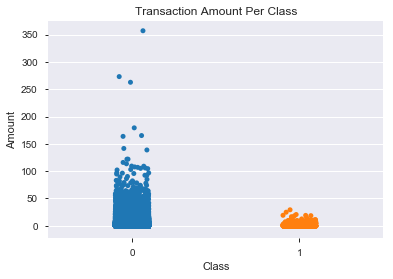

In [20]:
sns.stripplot(df['Class'], df['Amount']).set_title("Transaction Amount Per Class")

Max Fraud Amount: 2125.87
Number of Frauds above Quantile 3: 118


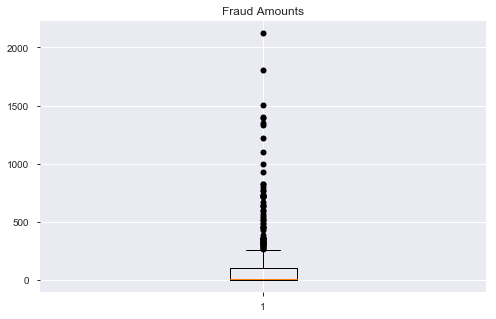

In [23]:
# A closer look at the distribution of transactions among frauds
plt.figure(figsize=(8,5))
df_fraud = df.loc[df['Class']==1]
plt.boxplot(df_fraud['Amount'], showfliers=True, sym='k')
plt.title("Fraud Amounts")
print("Max Fraud Amount:", df_fraud['Amount'].max())
print("Number of Frauds above Quantile 3:", len(df_fraud.loc[df_fraud['Amount'] > df_fraud['Amount'].quantile(.75)]))